## Exercice 3 : La Super-Résolution

**Objectif :** Reconstruire une image haute définition à partir d'une source dégradée.

* **Dataset :** **Flowers 102** ou **STL-10** (96x96), sinon **CIFAR-10**.
* **Seuils :** Entrée basse résolution et sortie haute résolution.
* **Méthode :** Réduisez la taille de l'image originale pour créer votre entrée.
* **Code pour Resize :** `x_train_low = tf.image.resize(x_train, [32, 32])`

In [54]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Resizing,  Add
from tensorflow.keras.layers import Conv2DTranspose

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [55]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (224, 224) # Redimensionnement automatique 

train_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,           
    validation_split=0.2,      
    subset='training',          
    seed=42                     
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,
    validation_split=0.2,
    subset='validation',         
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8189 files.
Using 6552 files for training.
Found 8189 files.
Using 1637 files for validation.


In [56]:
# --- trnsfomation into low qiality with normalisation, cration structure: (input, target) ---

LOW_SIZE = (32, 32)

def transform_low(ds):
    def to_low(image):
        image = tf.cast(image, tf.float32) / 255.0
        low_img  = tf.image.resize(image, LOW_SIZE)

        return low_img, image   # (input, target)

    ds_low = ds.map(to_low)
    ds_low = ds_low.cache().prefetch(tf.data.AUTOTUNE)

    return ds_low


train_low_ds = transform_low(train_ds)
val_low_ds = transform_low(val_ds)

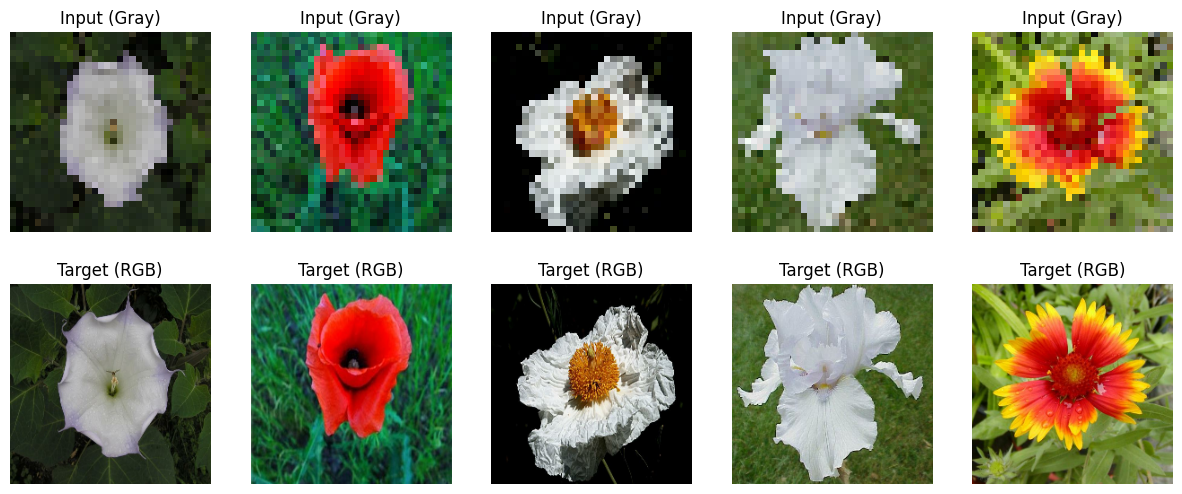

In [57]:
def show_images(ds, n=5):


    for x_batch, y_batch in ds.take(1):
        fig, axes = plt.subplots(2, n, figsize=(15, 6))
        batch_size = x_batch.shape[0]

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- grayscale (input) ---
            axes[0, i].imshow(tf.cast(x_batch[idx]*255, tf.uint8))
            axes[0, i].axis('off')
            axes[0, i].set_title('Input (Gray)')

            # --- RGB (target) ---
            axes[1, i].imshow(tf.cast(y_batch[idx]*255, tf.uint8))
            axes[1, i].axis('off')
            axes[1, i].set_title('Target (RGB)')

        plt.show()
        break

show_images(transform_low(train_ds), 5)

In [58]:
input_img = Input(shape=(32, 32, 3))  # Входное изображение 32x32

# --- Encoder ---
x = Conv2D(64, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

# ===== Residual block 1 =====
r = Conv2D(64, 3, padding='same', activation='relu')(x)
r = Conv2D(64, 3, padding='same')(r)
x = Add()([x, r])

# ===== Residual block 2 =====
r = Conv2D(64, 3, padding='same', activation='relu')(x)
r = Conv2D(64, 3, padding='same')(r)
x = Add()([x, r])

# ===== Residual block 3 =====
r = Conv2D(64, 3, padding='same', activation='relu')(x)
r = Conv2D(64, 3, padding='same')(r)
x = Add()([x, r])

# ===== Decoder / Upscaling =====
x = UpSampling2D(2)(x)   # 32 → 64
x = Conv2D(64, 3, padding='same', activation='relu')(x)

x = UpSampling2D(2)(x)   # 64 → 128
x = Conv2D(64, 3, padding='same', activation='relu')(x)

x = Resizing(224, 224)(x)
# --- Output --- 
output_img = Conv2D(3, 3, activation='sigmoid', padding='same')(x)  # 256x256x3

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_72[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_73[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_74[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ conv2d_73[0][0],  │
│                     │ 64)               │            │ conv2d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_6[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_76[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ add_6[0][0],      │
│                     │ 64)               │            │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_7[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_78[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 32,    │          0 │ add_7[0][0],      │
│                     │ 64)               │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ add_8[0][0]       │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 64,    │     36,928 │ up_sampling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 128,  │          0 │ conv2d_80[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 128, 128,  │     36,928 │ up_sampling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_6          │ (None, 224, 224,  │          0 │ conv2d_81[0][0] 

 Total params: 335,875 (1.28 MB)

 Trainable params: 335,875 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# --- autoencoder fitting ---

history = autoencoder.fit(
    train_low_ds,          # ВХОД → grayscale
    epochs=20,
    validation_data=val_low_ds  # Валидация
)

Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 326s 787ms/step - loss: 0.0121 - val_loss: 0.0082
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 294s 716ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 290s 709ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 291s 710ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 304s 742ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 324s 792ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 320s 782ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 320s 782ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 321s 783ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 322s 786ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 321s 783ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 12

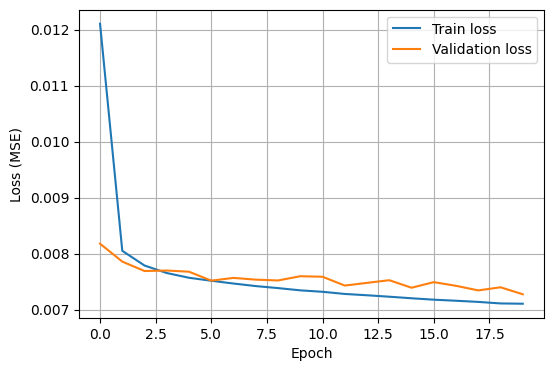

In [60]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

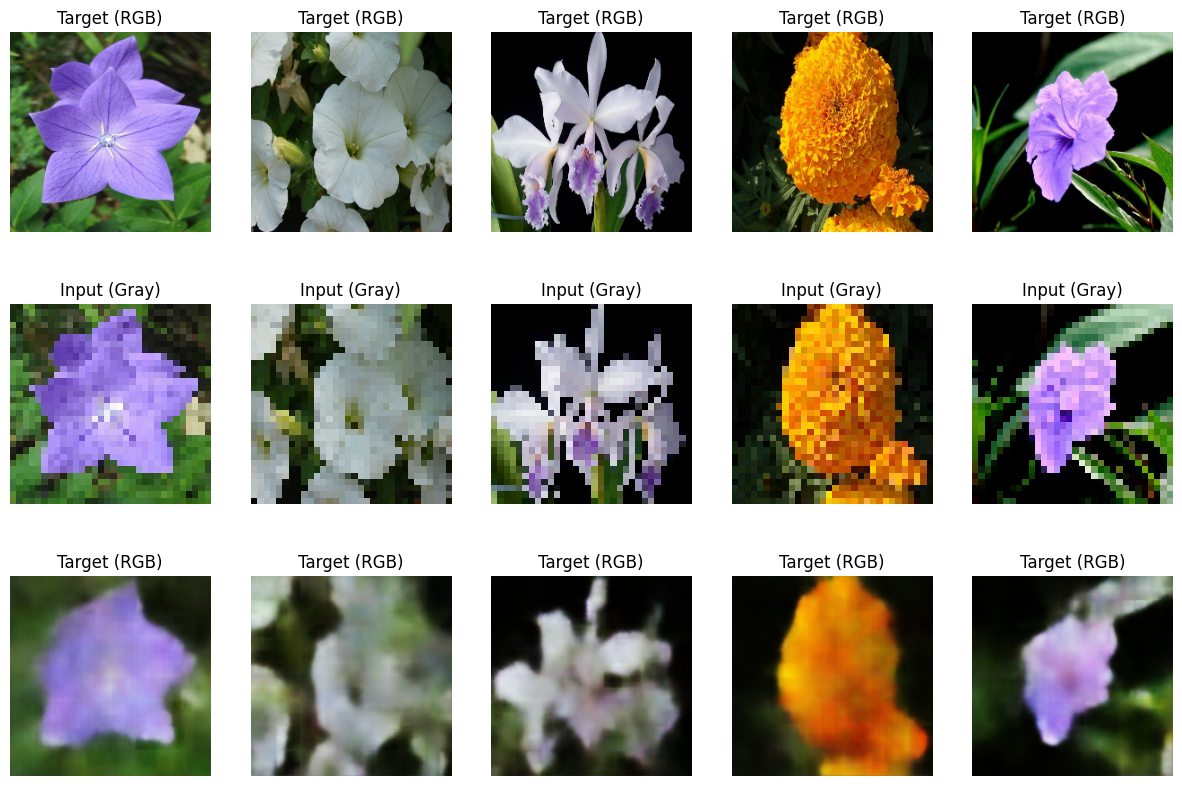

In [64]:
def show_images(ds, decoded_imgs , n=5):
    
    
    for x_batch, y_batch in ds.take(1):
        fig, axes = plt.subplots(3, n, figsize=(15, 10))
        batch_size = x_batch.shape[0]

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- grayscale (input) ---
            axes[1, i].imshow(tf.cast(x_batch[idx]*255, tf.uint8))
            axes[1, i].axis('off')
            axes[1, i].set_title('Input (Gray)')

            # --- RGB (target) ---
            axes[0, i].imshow(tf.cast(y_batch[idx]*255, tf.uint8))
            axes[0, i].axis('off')
            axes[0, i].set_title('Target (RGB)')

            # --- RGB (decoded) ---
            axes[2, i].imshow(tf.cast(decoded_imgs[idx]*255, tf.uint8))
            axes[2, i].axis('off')
            axes[2, i].set_title('Target (RGB)')

        plt.show()
        break

show_images(train_low_ds, decoded_imgs, n=5)